Plot Fig. 2d

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import BoundaryNorm, Normalize
from matplotlib.patches import Circle

from config import *
from CP4.utils.make_colorbar import MidpointNormalize
from CP4.make_composites.a3_make_multi_lvl_var_field import *
from CP4.make_composites.b3_make_multi_level_var_field_anomaly import load_multi_lvl_composite_mean_ano_field
from CP4.make_composites.significance.b3_compute_multi_level_var_field_significance_merge import load_multi_var_composite_significance_pvalues_merge
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [5]:
ds='CP4A'
res=4
var_ref='twb'
var='SM'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.  # km2
max_hw_size=1000000.  # km2
sw=[4., 4.]
tw=[-72, 72]
samtime=[0, 6]
n_days=3
meth='cc3d'
cnty=26
length=25.  # km
lvl=0.05
pvalue=0.01
regs=['WSahel', 'CSahel', 'ESahel']
flabel='d'

In [3]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

swlat = sw[0]
swlon = sw[1]
sw_ = str(swlat) + 'x' + str(swlon)

space_scale = str(min_hw_size) + '-' + str(max_hw_size)
space_scale_ = str(int(min_hw_size)) + '-' + str(int(max_hw_size))

tw_before = tw[0]
tw_after = tw[1]
assert tw_before <= tw_after, "Incorrect number of time steps"
tw_ = str(tw_before) + '_to_' + str(tw_after)

unit = 'mm'

ttl = 'Sahel'

In [6]:
#~ Get data

pvalues = load_multi_var_composite_significance_pvalues_merge(ds, res, var_ref, var, y0, y1, months, regs, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty, lvl)

out_hclim = []
out_ano = []

for reg in regs:
    coords = study_regions[reg]
    lat_range = coords[0]
    lon_range = coords[1]

    vardata = load_composite_multi_level_var(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty, lvl)

    varhclim = load_composite_multi_level_var_clim(ds, res, var_ref, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw, tw, lat_range, lon_range, min_hw_size, max_hw_size, meth, cnty, lvl)

    ds_ano = load_multi_lvl_composite_mean_ano_field(ds, res, var_ref, var, y0, y1, months, lat_range, lon_range, t_thresh, q_thresh, n_days, window, sw, tw, samtime, min_hw_size, max_hw_size, meth, cnty, lvl)

    out_hclim.append(varhclim)
    out_ano.append(ds_ano)

out_hclim = np.concatenate(out_hclim, axis=0)
out_ano = xr.concat(out_ano, dim='n')

In [7]:
#~ Treat data

tw_before = tw[1]+samtime[0]
tw_after = tw[1]+samtime[1]

varhclim_time = out_hclim[:,tw_before:tw_after+1,:,:].mean(axis=1)

unit_compo = unit

varhclim_mean = np.nanmean(varhclim_time, axis=0) # mean across events
varhclim_med = np.nanmedian(varhclim_time, axis=0) # median across events

var_hhee_ano_mean = np.nanmean(out_ano.values, axis=0) # mean across events
var_hhee_ano_med = np.nanmedian(out_ano.values, axis=0) # median across events

varhclim_2plot = varhclim_mean
var_hhee_ano_2plot = var_hhee_ano_mean

varhclimmean = np.nanmean(varhclim_2plot)  # spatial mean
varhclimmed = np.nanmedian(varhclim_2plot)
varanomean = np.nanmean(var_hhee_ano_2plot)  # spatial mean
varanomed = np.nanmedian(var_hhee_ano_2plot)

ncells = length / 4.4
assert (ncells < var_hhee_ano_mean.shape[0]) and (ncells < var_hhee_ano_mean.shape[1]), 'Length scale larger than spatial window!'

xs = np.linspace(-pvalues.shape[0]/2, pvalues.shape[0]/2, pvalues.shape[0])
ys = np.linspace(-pvalues.shape[1]/2, pvalues.shape[1]/2, pvalues.shape[1])

xc = (xs[-1]-xs[0])/2+xs[0]
yc = (ys[-1]-ys[0])/2+ys[0]

xsm, ysm = np.meshgrid(xs, ys)

r = length / 4.4  # nb of grid points

distloc = ( ((xsm - xc) * (xsm - xc)) + ((ysm - yc) * (ysm - yc)) )**.5  # 2d-array of distance to center values
disc_mask = np.broadcast_to(distloc <= r, out_ano.shape)
circ_mask = ((r-r/15 <= distloc) & (distloc <= r+r/15))

xscirc = xsm[circ_mask]
yscirc = ysm[circ_mask]

vals_clim_disc = ma.masked_array(varhclim_time, ~disc_mask)    # mask: True = masked
vals_clim_disc = ma.filled(vals_clim_disc, fill_value=np.nan)
vals_clim_disc_med = np.nanmean(vals_clim_disc, axis=0) # median across events
vals_clim_disc_mean = np.nanmean(vals_clim_disc_med)  # spatial mean

vals_ano_disc = ma.masked_array(out_ano.values, ~disc_mask)
vals_ano_disc = ma.filled(vals_ano_disc, fill_value=np.nan)
vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # median across events
vals_ano_disc_mean = np.nanmean(vals_ano_disc_med)  # spatial mean

pvalues_ = pvalues.where(pvalues > pvalue, np.nan)
pvalues_.values[~np.isnan(pvalues_)] = 1

/tmp/ipykernel_470105/2698553475.py:46: RuntimeWarning: Mean of empty slice
  vals_clim_disc_med = np.nanmean(vals_clim_disc, axis=0) # median across events
/tmp/ipykernel_470105/2698553475.py:51: RuntimeWarning: Mean of empty slice
  vals_ano_disc_med = np.nanmean(vals_ano_disc, axis=0) # median across events


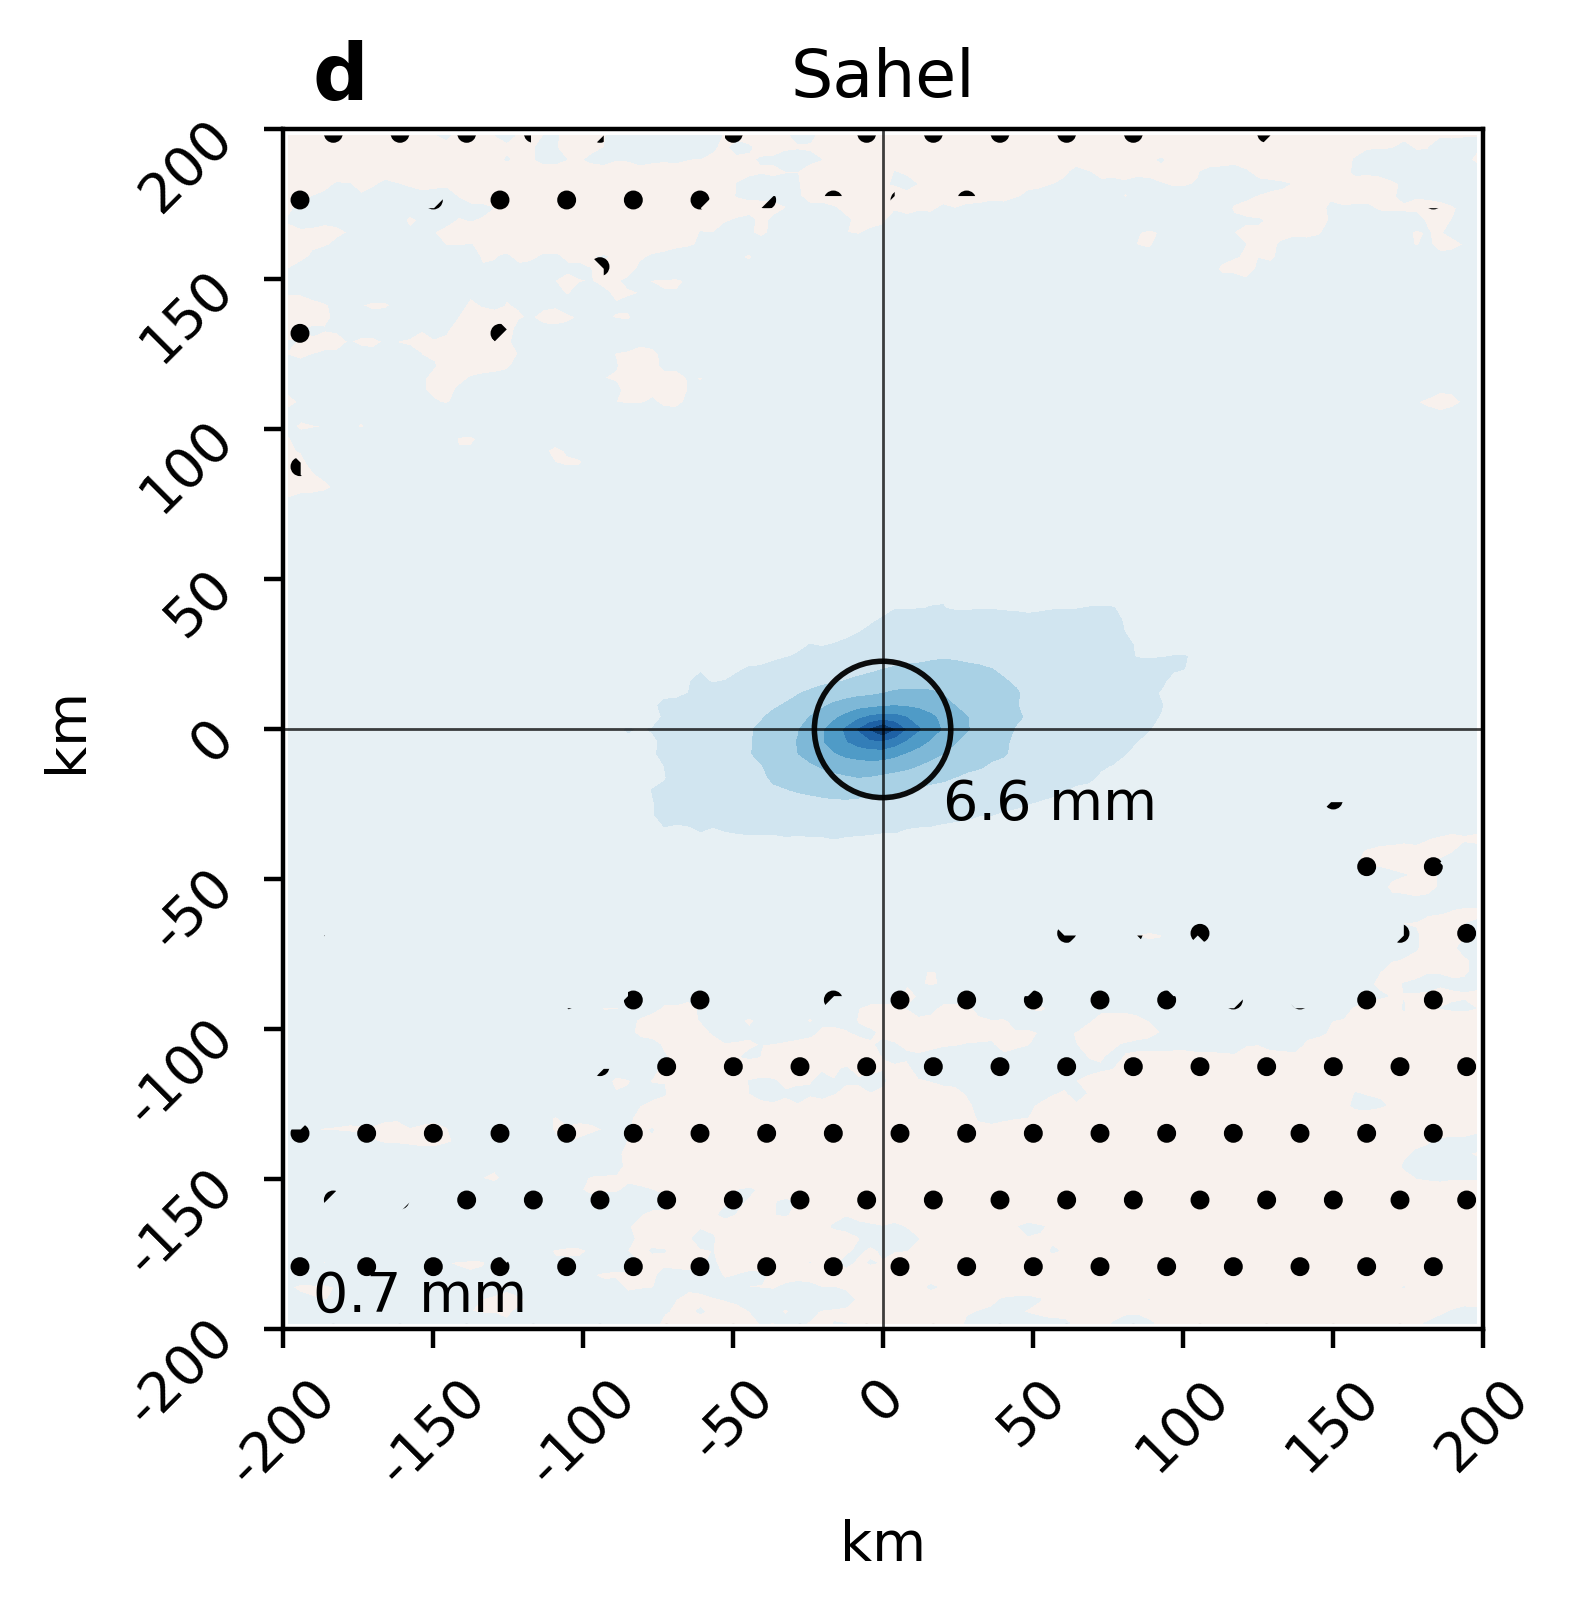

In [9]:
#~ Plot

circle_ano = Circle((xs[int(len(xs)/2)], ys[int(len(ys)/2)]), r, facecolor='none', edgecolor='k', linewidth=1, alpha=0.95)

xtlbs = np.arange(-200, 200+50, 50)
xtcks = xtlbs / res
ytlbs = np.arange(-200, 200+50, 50)
ytcks = ytlbs / res

anomin = clim_vars_ano[var_ref][var][0]
anomax = clim_vars_ano[var_ref][var][1]

cmap_ano = 'RdBu'

cmap = plt.get_cmap(cmap_ano)
bounds = np.linspace(anomin, anomax, 11)
norm = MidpointNormalize(vmin=anomin, vmax=anomax, midpoint=0)


fig_ano, ax_ano = plt.subplots(ncols=1, dpi=400)

plt.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.9)

p_ano = ax_ano.contourf(xs, ys, var_hhee_ano_2plot, levels=bounds, norm=norm, cmap=cmap)

ax_ano.contourf(xs, ys, pvalues_, hatches=['.'], colors='none')

ax_ano.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax_ano.transAxes)
ax_ano.text(0.55, 0.425, '%.1f %s'% (vals_ano_disc_mean, unit), transform=ax_ano.transAxes)
ax_ano.text(0.025, 0.015, '%.1f %s'% (varanomean, unit), transform=ax_ano.transAxes)

ax_ano.add_patch(circle_ano)

ax_ano.axhline(yc, 0, 1, color='k', alpha=0.75, lw=0.5)
ax_ano.axvline(xc, 0, 1, color='k', alpha=0.75, lw=0.5)

ax_ano.set_aspect('equal')
ax_ano.set_xlabel('km')
ax_ano.set_ylabel('km')
ax_ano.set_xticks(xtcks)
ax_ano.set_xticklabels(xtlbs, rotation=45)
ax_ano.set_yticks(ytcks)
ax_ano.set_yticklabels(ytlbs, rotation=45)
ax_ano.set_title(ttl)

fig_ano.set_size_inches(4., 4.)

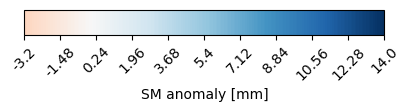

In [11]:
fig_cb_ano, ax_cb_ano = plt.subplots(figsize=(4.5, 1.))

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.65, top=0.9)

cbtks = bounds
cblbs = [str(round(b,2)) for b in bounds]

cb_ano = fig_cb_ano.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cb_ano, orientation='horizontal', label='%s anomaly [%s]'% (var, unit_compo), shrink=0.95, pad=0.15)
cb_ano.ax.tick_params(labelrotation=45.)
cb_ano.set_ticks(cbtks)
cb_ano.set_ticklabels(cblbs)